In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import glob
check = glob.glob("/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data/train/" + '*.png')
print(len(check))
a = [0, 0, 0, 0, 0]
for x in check:
    x = x.split("/")[-1]
    a[int(x[0])] += 1
print(a)

9115
[1823, 1823, 1823, 1823, 1823]


In [3]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

# %matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm
import json
import os.path as osp
import argparse
import glob

from random import *
import pandas as pd


def set_seed(seed=123):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

#Utils

In [4]:
class ImageTransform:
    def __init__(self, resize):
        self.data_transform = transforms.Compose(
            [
                transforms.Resize(resize),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]
        )

    def __call__(self, img, phase="train"):
        return self.data_transform(img)


def make_lfile(rootpath):
  with open(rootpath +"/labels.json", encoding="utf-8") as json_file:
    data = json.load(json_file)
    flist = data.keys()
  return  list(flist)

# list_image, list_label = make_datapath_list(phase="test_data")
# print(list_image)


class MyDataset(data.Dataset):
    def __init__(self, root,flist, transform=None):
        self.flist = flist
        self.root = root
        self.transform = transform
        with open(root + "/" + "labels.json",encoding='utf-8') as json_file:
          data = json.load(json_file)
        self.dict_label = data

    def __len__(self):
        return len(self.flist)

    def __getitem__(self, idx):
        name_image = self.flist[idx]
        # print(name_image)
        # Nếu chuyển ảnh về gray
        # img = Image.open(img_path).convert("1")
        img_path = osp.join(self.root, name_image)
        # print(img_path)
        img = Image.open(img_path).convert("1")
        img_transformed = self.transform(img)

        label = self.dict_label[name_image]
        return img_transformed, label



In [5]:
import collections
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        # self.alphabet = alphabet + ' '  # for `-1` index
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)  
                
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

#Model

In [6]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut, dropout=0):
        """
        nIn : number of input features
        nOut : number of output  features
        nHidden : number of hidden features
        input shape : if batch_first= False(default)  seq_len, batch, nIn
        hidden_state shape: n_layer * number_direc , batch,hidden_size
        out shape : seq_len, batch, num_direc * hidden_size
        """
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        recurrent = self.dropout(recurrent)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        """
        nc : n_ chanel
        nh : n_hidden_state of rnn
        imgH: image high size
        input Conv2d :(batch_size, channel_in, High_in, Width_in)
        High_in = 32
        """

        super(CRNN, self).__init__()
        assert imgH % 16 == 0, "imgH has to be a multiple of 16"

        self.log_softmax = nn.LogSoftmax(-1)
        # kernel size
        ks = [3, 3, 3, 3, 3, 3, 2]
        # padding size
        ps = [1, 1, 1, 1, 1, 1, 0]
        # stride size
        ss = [1, 1, 1, 1, 1, 1, 1]

        # n_
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=True):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module(
                "conv{0}".format(i), nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i])
            )
            if batchNormalization:
                cnn.add_module("batchnorm{0}".format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module("relu{0}".format(i), nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module("relu{0}".format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module("pooling{0}".format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module("pooling{0}".format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2)
        convRelu(3)
        cnn.add_module(
            "pooling{0}".format(2), nn.MaxPool2d((2, 2), (2, 2), (0, 0))
        )  # 256x4x16
        convRelu(4)
        convRelu(5)
        cnn.add_module(
            "pooling{0}".format(3), nn.MaxPool2d((2, 2), (2, 1), (0, 0))
        )  # 512x2x16
        convRelu(6)  # 512x1x16

        self.cnn = cnn
        # nh  = n_hidden

        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh, 0), BidirectionalLSTM(nh, nh, nclass, 0)
        )

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        # print("output conv.shape", conv.shape)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # print("input rnn.shape", conv.shape)
        # rnn features
        output = self.rnn(conv)
        # print("output.shape: ", output.shape)
        return self.log_softmax(output)

#Hyperparams

In [7]:
train_path = "/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data/validate"

alphabet = open(osp.join("/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data","alphabet.txt")).read().rstrip()
nclass = len(alphabet) + 1

lr = 0.01
epochs = 9
batch_size = 32
# mean = (0.485, 0.456, 0.406)
# std = (0.229, 0.224, 0.225)
mean = (0.5,)
std = (0.5,)
resize = (32, 824)

#Dataloader

In [8]:
converter = strLabelConverter(alphabet, ignore_case=False)
print(converter.dict)
train_dataset = MyDataset(train_path, make_lfile(train_path), transform=ImageTransform(resize))
val_dataset = MyDataset(val_path, make_lfile(val_path), transform=ImageTransform(resize))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
dataloader_dict = {"train":train_dataloader, "val":val_dataloader}

{'!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '+': 9, ',': 10, '-': 11, '.': 12, '/': 13, ' ': 14, '#': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '?': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, '\\': 56, ']': 57, '^': 58, '_': 59, 'a': 60, 'b': 61, 'c': 62, 'd': 63, 'e': 64, 'f': 65, 'g': 66, 'h': 67, 'i': 68, 'j': 69, 'k': 70, 'l': 71, 'm': 72, 'n': 73, 'o': 74, 'p': 75, 'q': 76, 'r': 77, 's': 78, 't': 79, 'u': 80, 'v': 81, 'w': 82, 'x': 83, 'y': 84, 'z': 85, '{': 86, '|': 87, '}': 88, '°': 89, '²': 90, 'À': 91, 'Á': 92, 'Â': 93, 'Ã': 94, 'È': 95, 'É': 96, 'Ê': 97, 'Ì': 98, 'Í': 99, 'Ð': 100, 'Ò': 101, 'Ó': 102, 'Ô': 103, 'Õ': 104, 'Ö': 105, 'Ù': 106, 'Ú': 107, 'Ü': 108, 'Ý': 109, 'à': 110, 'á': 1

#Train

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [10]:
from torch.nn import CTCLoss
ctc_loss = CTCLoss().to(DEVICE)
model = CRNN(224, nc=1, nclass=nclass, nh=32).to(DEVICE)
optimizer = optim.AdamW(params=model.parameters(), lr =lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform(m.weight.data)
   
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        # nn.init.xavier_uniform(m.bias.data)

    # if isinstance(m,nn.LSTM):
        # nn.init.xavier_uniform(m.weight.data)
        # nn.init.xavier_uniform(m.bias.data)

model.apply(weights_init)
print("Done")

Done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
from tqdm.auto import tqdm
train_loss = []
val_loss = []
for i in range(epochs):
  model.train()  
  train_epoch_loss = 0.0
  for inputs, text in tqdm(dataloader_dict['train']):
      optimizer.zero_grad()
      inputs = inputs.to(DEVICE)
      outputs = model(inputs)
      output_length = torch.full(size=(inputs.shape[0],), fill_value=outputs.shape[0], dtype=torch.long).cuda()
      label,l = converter.encode(text)
      label = label.to(DEVICE)
      l = l.to(DEVICE)
      loss = ctc_loss(outputs.float(), label.float() ,output_length, l)
      loss.backward()
      optimizer.step()             
      train_epoch_loss += loss.item()                   
  train_epoch_loss = train_epoch_loss / len(dataloader_dict['train'])  
  train_loss.append(train_epoch_loss)

  with torch.no_grad():
      val_epoch_loss = 0.0
      model.eval()
      for inputs, text in dataloader_dict['val']:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        output_length = torch.full(size=(inputs.shape[0],), fill_value=outputs.shape[0], dtype=torch.long,device=DEVICE)
        label,l = converter.encode(text)
        label = label.to(DEVICE)
        l = l.to(DEVICE)
        loss = ctc_loss(outputs.float(), label.float(),output_length,l)             
        val_epoch_loss += loss.item()
      val_epoch_loss = val_epoch_loss / len(dataloader_dict['val'])   
      val_loss.append(val_epoch_loss)

  print("epochs {}/{} Train_loss :{} Val_loss : {} ".format(i+1,epochs,train_epoch_loss,val_epoch_loss))


epochs 1/9 Train_loss :3.390762960701658 Val_loss : 2.786253889401754 



epochs 2/9 Train_loss :2.145297902927064 Val_loss : 2.5856178071763782 



epochs 3/9 Train_loss :1.4371007768731368 Val_loss : 1.450495978196462 



epochs 4/9 Train_loss :0.9489328325840465 Val_loss : 1.158605436484019 



epochs 5/9 Train_loss :0.6423072841083795 Val_loss : 0.9931898017724355 



epochs 6/9 Train_loss :0.44428694509623345 Val_loss : 0.7958936790625254 



epochs 7/9 Train_loss :0.3250229517095967 Val_loss : 0.7685538977384567 



epochs 8/9 Train_loss :0.24983338049629278 Val_loss : 0.7696432603730096 



epochs 9/9 Train_loss :0.19188107312248465 Val_loss : 0.71336796383063 


##More training

In [ ]:
pre_epochs = epochs
epochs += 1
for i in range(pre_epochs, epochs):
  model.train()  
  train_epoch_loss = 0.0
  for inputs, text in tqdm(dataloader_dict['train']):
      optimizer.zero_grad()
      inputs = inputs.to(DEVICE)
      outputs = model(inputs)
      output_length = torch.full(size=(inputs.shape[0],), fill_value=outputs.shape[0], dtype=torch.long).cuda()
      label,l = converter.encode(text)
      label = label.to(DEVICE)
      l = l.to(DEVICE)
      loss = ctc_loss(outputs.float(), label.float() ,output_length, l)
      loss.backward()
      optimizer.step()             
      train_epoch_loss += loss.item()                   
  train_epoch_loss = train_epoch_loss / len(dataloader_dict['train'])  
  train_loss.append(train_epoch_loss)

  with torch.no_grad():
      val_epoch_loss = 0.0
      model.eval()
      for inputs, text in dataloader_dict['val']:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        output_length = torch.full(size=(inputs.shape[0],), fill_value=outputs.shape[0], dtype=torch.long,device=DEVICE)
        label,l = converter.encode(text)
        label = label.to(DEVICE)
        l = l.to(DEVICE)
        loss = ctc_loss(outputs.float(), label.float(),output_length,l)             
        val_epoch_loss += loss.item()
      val_epoch_loss = val_epoch_loss / len(dataloader_dict['val'])   
      val_loss.append(val_epoch_loss)

  print("epochs {}/{} Train_loss :{} Val_loss : {} ".format(i+1,epochs,train_epoch_loss,val_epoch_loss))


epochs 10/10 Train_loss :0.15182525761294782 Val_loss : 0.7420086281167136 


# Save and Load model

In [11]:
import os
sub_folder = "biimg_" + "resize" + str(resize[1]) + "_batch" + str(batch_size) + "_epoch" + str(epochs)
path = "/content/drive/MyDrive/Colab Notebooks/OCR/saved_model/" + sub_folder
try:
    # Create target Directory
    os.mkdir(path)
    print("Directory " , path ,  " Created ") 
except FileExistsError:
    print("Directory " , path ,  " already exists")

Directory  /content/drive/MyDrive/Colab Notebooks/OCR/saved_model/biimg_resize824_batch32_epoch9  already exists


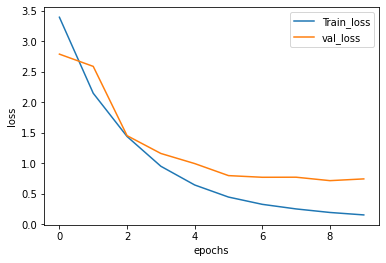

In [ ]:
plt.plot(range(epochs),train_loss, label= 'Train_loss')
plt.plot(range(epochs),val_loss, label= 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig(path + "/loss_more.png")

In [ ]:
def save_model(checkpoints, location):
    print("Saving models:")
    torch.save(checkpoints, location)

checkpoints = {'model_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
save_model(checkpoints=checkpoints, location=path + "/weights.pth.rar")

Saving models:


In [12]:
def load_model(model, optim, checkpoints):
    print("Loading model")
    model.load_state_dict(checkpoints["model_dict"])
    optim.load_state_dict(checkpoints["optimizer"])

load_model(model,optimizer, torch.load(path + "/weights.pth.rar"))

Loading model


#Test

In [13]:
from scipy.special import softmax
from IPython import display

In [14]:
testdatapath = "/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data/validate/"

In [15]:
def beam_search_decoder(data, k=20):
    data = torch.squeeze(data.cpu()).detach().numpy()
    data = softmax(data, axis=1)
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [16]:
i = 14
a, b = val_dataset.__getitem__(i)
a = torch.unsqueeze(a,0)
a = a.to(DEVICE)
output = model(a)
o = torch.argmax(output, dim=2)
print(b)

49 Tự Phước, Thành phố Đà Lạt, Lâm Đồng


In [23]:
results = beam_search_decoder(output, k=100)

49 Tự Phước, Thành phố Đà Lạt, Lâm Đồng
________________________________________________________________________________
49 Tự Phước, Trành phố Đà Lạt, Lâm Đồng                                | 0.9744
4 Tự Phước, Trành phố Đà Lạt, Lâm Đồng                                 | 0.9487
49 Tự Phước, Thành phố Đà Lạt, Lâm Đồng                                | 1.0000
490 Tự Phước, Trành phố Đà Lạt, Lâm Đồng                               | 0.9500
4 Tự Phước, Thành phố Đà Lạt, Lâm Đồng                                 | 0.9744
49 Tự Phước, Tành phố Đà Lạt, Lâm Đồng                                 | 0.9744
40 Tự Phước, Trành phố Đà Lạt, Lâm Đồng                                | 0.9487
490 Tự Phước, Thành phố Đà Lạt, Lâm Đồng                               | 0.9750
4 Tự Phước, Tành phố Đà Lạt, Lâm Đồng                                  | 0.9487
40 Tự Phước, Thành phố Đà Lạt, Lâm Đồng                                | 0.9744


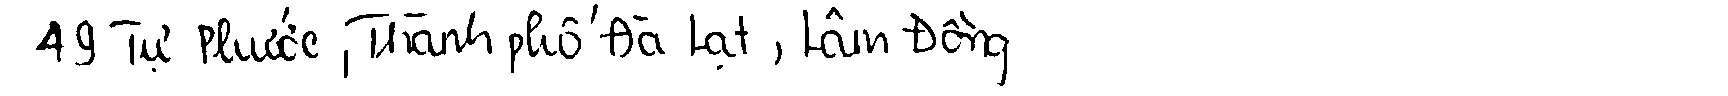

In [24]:
print(b)
print("_" * 80)
final_results = {}
for result in results:
    y = torch.cuda.IntTensor(result[0])
    y = torch.unsqueeze(y, 1)
    y = converter.decode(y, torch.IntTensor([resize[1] / 8 - 2]))
    if y not in final_results:
        final_results[y] = 1
    else:
        final_results[y] += 1
for key in final_results.keys():
    print("{:70s} | {:2.4f}".format(key, string_similarity(b, key)))
imagefilename = str(i).zfill(4) + "_tests.png"
display.Image(testdatapath + imagefilename)

In [25]:
final_results

{'4 Tự Phước, Thành phố Đà Lạt, Lâm Đồng': 6,
 '4 Tự Phước, Trành phố Đà Lạt, Lâm Đồng': 15,
 '4 Tự Phước, Tành phố Đà Lạt, Lâm Đồng': 2,
 '40 Tự Phước, Thành phố Đà Lạt, Lâm Đồng': 1,
 '40 Tự Phước, Trành phố Đà Lạt, Lâm Đồng': 5,
 '49 Tự Phước, Thành phố Đà Lạt, Lâm Đồng': 16,
 '49 Tự Phước, Trành phố Đà Lạt, Lâm Đồng': 32,
 '49 Tự Phước, Tành phố Đà Lạt, Lâm Đồng': 6,
 '490 Tự Phước, Thành phố Đà Lạt, Lâm Đồng': 5,
 '490 Tự Phước, Trành phố Đà Lạt, Lâm Đồng': 12}

In [ ]:
mat = np.array([re[0] for re in results])
mat = mat.T
mat

array([[ 47,  47,  47, ...,  47,  47,  47],
       [196, 196, 196, ..., 196, 196, 196],
       [ 14,  14,  14, ...,  14,  14,  14],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
nmat = np.array([np.bincount(m).argmax() for m in mat])
nmat

array([ 47, 196,  14,  17,  17,  16,  10,  14, 134, 146, 146, 208,  73,
        73,  66,  14,  40,   0, 128,   0,  14,  50,   0, 132,  73,  14,
        14,  40, 112,  72,   0,  10,  10,  14,  44,  44,  67, 146, 208,
        73,  73,  66,  14,  14,  20,  10,  14,  48,  67, 110,  73,  73,
        67,  14,  14,  44,  44,  67, 196, 196,  14,  31,   0, 110,  14,
        14,  41,   0,   0,  60,  80,   0,  10,  10,  14,  14,  32, 110,
        14,  14,  41,   0,   0,  60,  80,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
y = torch.cuda.IntTensor(nmat)
y = torch.unsqueeze(y, 1)
y = converter.decode(y, torch.IntTensor([resize[1] / 8 - 2]))
y

'Số 10, đường Lý Văn Lâm, Phường 4, Thành Phố Cà Mau, Dà Mau'

In [17]:
import editdistance

In [18]:
def string_similarity(target, got):
    return 1 - 1.0 * editdistance.eval(target, got) / max(len(target), len(got))

In [ ]:
string_similarity(b, y)

0.9661016949152542

#Study

In [ ]:
print(model)

CRNN(
  (log_softmax): LogSoftmax(dim=-1)
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(256, eps=1e-0

##Read Image

In [ ]:
datapath = "/content/drive/MyDrive/Colab Notebooks/OCR/Cinnamon_VN_data/0916_Data Samples 2/"

In [ ]:
id = 369
image = Image.open(datapath + str(id).zfill(4) + "_samples.png").convert("RGB")

In [ ]:
image2 = image.resize((2000, 200))

In [ ]:
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [ ]:
add_margin(image, 0, 0, 0, 50, (0, 0, 0)).resize((2000, 200))

In [ ]:
image.convert('1').mode

'1'

In [ ]:
import colorsys
from PIL import Image
def ipreprocess_image(img):
    ld = img.load()
    width, height = img.size
    for y in range(height):
        for x in range(width):
            r, g, b = ld[x, y]
            h, s, v = colorsys.rgb_to_hsv(r/255., g/255., b/255.)

            if s > 0.5:                     # <--- here onwards is my attempted Python
                ld[x, y] = (0, 0, 0)
            else:
                ld[x, y] = (255, 255, 255)
    return img

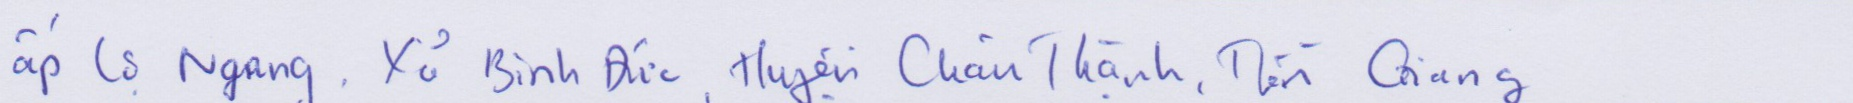

In [ ]:
image

In [ ]:
import cv2

In [ ]:
import cv2
import numpy as np
id = 1043
# load color image
im = cv2.imread(datapath + str(id).zfill(4) + "_samples.png")

# smooth the image with alternative closing and opening
# with an enlarging kernel
morph = im.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# take morphological gradient
gradient_image = cv2.morphologyEx(morph, cv2.MORPH_GRADIENT, kernel)

# split the gradient image into channels
image_channels = np.split(np.asarray(gradient_image), 3, axis=2)

channel_height, channel_width, _ = image_channels[0].shape

# apply Otsu threshold to each channel
for i in range(0, 3):
    _, image_channels[i] = cv2.threshold(~image_channels[i], 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    image_channels[i] = np.reshape(image_channels[i], newshape=(channel_height, channel_width, 1))

# merge the channels
image_channels = np.concatenate((image_channels[0], image_channels[1], image_channels[2]), axis=2)

# save the denoised image
cv2.imwrite('output.png', image_channels)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

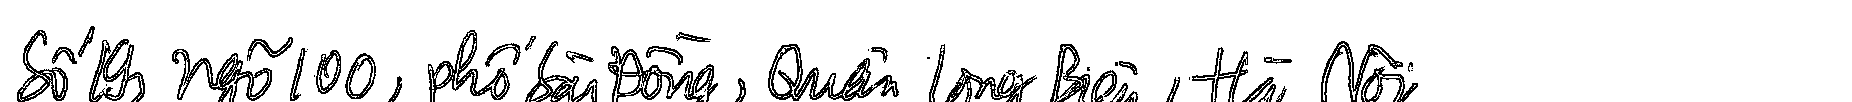

In [ ]:
new_img = Image.open('output.png').convert('1')
new_img

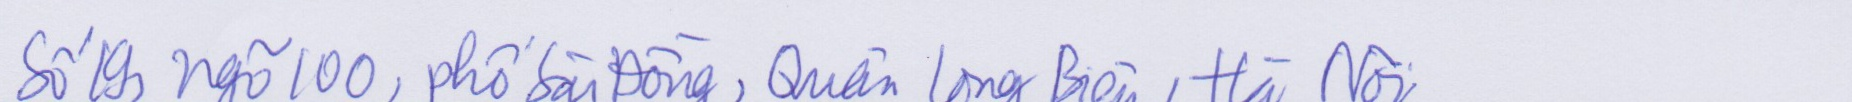

In [ ]:
Image.open(datapath + str(id).zfill(4) + "_samples.png").convert("RGB")

In [ ]:
image_channels.shape

(102, 1852, 3)